# **Airline Customer Segmentation**

## **Objectives**

1. Classify customer segmentation and characteristics of each cluster.
2. Create personalized marketing strategy recommendations for each cluster based on characteristics.

## **Import Libraries**

In [206]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [207]:
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("bmh")
colors = ['#053c5e', '#1d3958', '#353652', '#4c334d', '#643047', '#7c2e41', '#942b3b', '#ab2836', '#c32530', '#db222a']

## **Function Helper Definition**

In [208]:
def data_info(data) :
    pd.set_option('display.max_rows',None)
    missing_values = data.isnull().sum()
    missing_perc = (missing_values/len(data))*100
    data_type = data.dtypes
    num_unique = data.nunique()

    print (f'Rows,Columns {data.shape}')
    print (f'Duplicated Values {data.duplicated().sum()}')
    print('=====')

    check_df = pd.DataFrame ({'missingValue' : missing_values,
                          'percentMissing' : missing_perc,
                          'DataType' : data_type,
                          'Unique' : num_unique}).sort_values('percentMissing',ascending=False)

    return check_df

In [209]:
def outlier(df, column) :
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)

    outlier_count = 0

    def check_outlier(x):
        nonlocal outlier_count
        if x < lower or x > upper:
            outlier_count += 1

    df[column].apply(check_outlier)

    outlier_perc = round((outlier_count) / len(df) * 100, 2)

    print(f'===== {column} =====')
    print (f' outlier lower limit : {lower} \n outlier upper limit : {upper}')
    print(f'Number of outliers: {outlier_count} ({outlier_perc}%)\n')

    return outlier_perc

## **Base Data Information**

In [210]:
df = pd.read_csv('flight.csv')

In [211]:
df.shape

(62988, 23)

In [212]:
df.head(3)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26


## **Data Understanding**

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [214]:
feats = list(df)
for column in feats:
    print(f"{column} : {df[column].unique()}\n")

MEMBER_NO : [54993 28065 55106 ... 45690 61027 61340]

FFP_DATE : ['11/2/2006' '2/19/2007' '2/1/2007' ... '5/3/2009' '1/25/2010' '5/19/2009']

FIRST_FLIGHT_DATE : ['12/24/2008' '8/3/2007' '8/30/2007' ... '3/30/2014' '3/25/2014'
 '3/24/2014']

GENDER : ['Male' 'Female' nan]

FFP_TIER : [6 5 4]

WORK_CITY : ['.' nan 'Los Angeles' ... 'BELLREGUARD' 'Danville' 'lingshui']

WORK_PROVINCE : ['beijing' 'CA' 'guizhou' ... 'NOTARIO' 'TOPKPPI' 'JAWATIMUR']

WORK_COUNTRY : ['CN' 'US' 'FR' 'AN' 'JP' 'HK' 'MY' 'AU' 'NL' 'MX' 'CA' 'KR' 'PK' 'TH'
 'SG' 'BR' 'PE' 'AE' 'HN' 'PH' 'ID' 'MO' 'GN' 'FL' 'KH' nan 'TW' 'VN' 'DE'
 'IL' 'CH' 'PA' 'VT' 'EC' 'NG' 'BI' 'GT' 'BE' 'GL' 'NZ' 'FA' 'NI' 'KO'
 'CC' 'UV' 'MN' 'UK' 'AS' 'IT' 'OM' 'SE' 'BZ' 'IN' 'KZ' 'PT' 'NO' 'MS'
 'FI' 'UZ' 'NE' 'AT' 'AA' 'HU' 'CY' 'EG' 'MA' '中' 'ES' 'MZ' 'IR' 'SW' 'RE'
 'PS' 'KE' 'SN' 'BB' 'AZ' 'UA' 'LB' 'YE' 'GE' 'SI' 'KA' 'MV' 'RO' 'ZA'
 'DK' 'AB' 'CD' 'UY' 'CM' 'TK' 'AR' 'BN' 'PN' 'BD' '北' 'SU' 'RU' '沈' 'GU'
 'GB' 'ZW' 'PP' '芬' 'FO' 

There is a total of 62988 data with 23 features.

In [215]:
# Remove MEMBER_NO since it's too much unique data
df = df.drop('MEMBER_NO', axis=1)

### **Numerical Data**

In [216]:
num_types = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_col = df.select_dtypes(include=num_types).columns
print(num_col)
print()

num_shape = df.select_dtypes(include=num_types).shape
print(num_shape)

df_num = df.select_dtypes(include=num_types)
df_num.head(3)

Index(['FFP_TIER', 'AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2',
       'SEG_KM_SUM', 'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL',
       'EXCHANGE_COUNT', 'avg_discount', 'Points_Sum', 'Point_NotFlight'],
      dtype='object')

(62988, 14)


,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,6,31.0,210,505308,239560.0,234188.0,580717,1,3.483254,18,34,0.961639,619760,50
1,6,42.0,140,362480,171483.0,167434.0,293678,7,5.194245,17,29,1.252314,415768,33
2,6,40.0,135,351159,163618.0,164982.0,283712,11,5.298507,18,20,1.254676,406361,26


15 features are numerical (if we include MEMBER_NO).

### **Non Numerical Data**

In [217]:
non_num_col = df.select_dtypes(exclude=num_types).columns
print(non_num_col)
print()

non_num_shape = df.select_dtypes(exclude=num_types).shape
print(non_num_shape)

df_non_num = df.select_dtypes(exclude=num_types)
df_non_num.head(3)

Index(['FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'WORK_CITY', 'WORK_PROVINCE',
       'WORK_COUNTRY', 'LOAD_TIME', 'LAST_FLIGHT_DATE'],
      dtype='object')

(62988, 8)


,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,LOAD_TIME,LAST_FLIGHT_DATE
0,11/2/2006,12/24/2008,Male,.,beijing,CN,3/31/2014,3/31/2014
1,2/19/2007,8/3/2007,Male,NaN,beijing,CN,3/31/2014,3/25/2014
2,2/1/2007,8/30/2007,Male,.,beijing,CN,3/31/2014,3/21/2014


8 features are non numerical. Out of 8 featres, 4 of them are dates: `FFP_DATE`, `FIRST_FLIGHT_DATE`, `LOAD_TIME`, `LAST_FLIGHT_DATE` which may need to be turned to `datetime`.

## **Exploratory Data Analysis**

### **Descriptive Statistics**

In [218]:
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
FFP_TIER,62988.0,4.102162,0.373856,4.0,4.000000,4.000000,4.000000,6.0
AGE,62568.0,42.476346,9.885915,6.0,35.000000,41.000000,48.000000,110.0
FLIGHT_COUNT,62988.0,11.839414,14.049471,2.0,3.000000,7.000000,15.000000,213.0
BP_SUM,62988.0,10925.081254,16339.486151,0.0,2518.000000,5700.000000,12831.000000,505308.0
SUM_YR_1,62437.0,5355.376064,8109.450147,0.0,1003.000000,2800.000000,6574.000000,239560.0
SUM_YR_2,62850.0,5604.026014,8703.364247,0.0,780.000000,2773.000000,6845.750000,234188.0
SEG_KM_SUM,62988.0,17123.878691,20960.844623,368.0,4747.000000,9994.000000,21271.250000,580717.0
LAST_TO_END,62988.0,176.120102,183.822223,1.0,29.000000,108.000000,268.000000,731.0
AVG_INTERVAL,62988.0,67.749788,77.517866,0.0,23.370370,44.666667,82.000000,728.0
MAX_INTERVAL,62988.0,166.033895,123.397180,0.0,79.000000,143.000000,228.000000,728.0


* `AGE` is concerning, minimal flight age is 6. But I assume their parents help set up their account to book flights.
* `EXCHANGE_COUNT` has 0 on 25%, 50%, and 75%, meanwhile `Point_NotFlight` has 0 on 25%, and 50%. Assuming these are conditional statements, therefore we do not remove outliers from them.

In [219]:
df_non_num.describe().T

,count,unique,top,freq
FFP_DATE,62988,3068,1/13/2011,184
FIRST_FLIGHT_DATE,62988,3406,2/16/2013,96
GENDER,62985,2,Male,48134
WORK_CITY,60719,3234,guangzhou,9386
WORK_PROVINCE,59740,1165,guangdong,17509
WORK_COUNTRY,62962,118,CN,57748
LOAD_TIME,62988,1,3/31/2014,62988
LAST_FLIGHT_DATE,62988,731,3/31/2014,959


### **Univariate Analysis**

#### **Numerical Data**

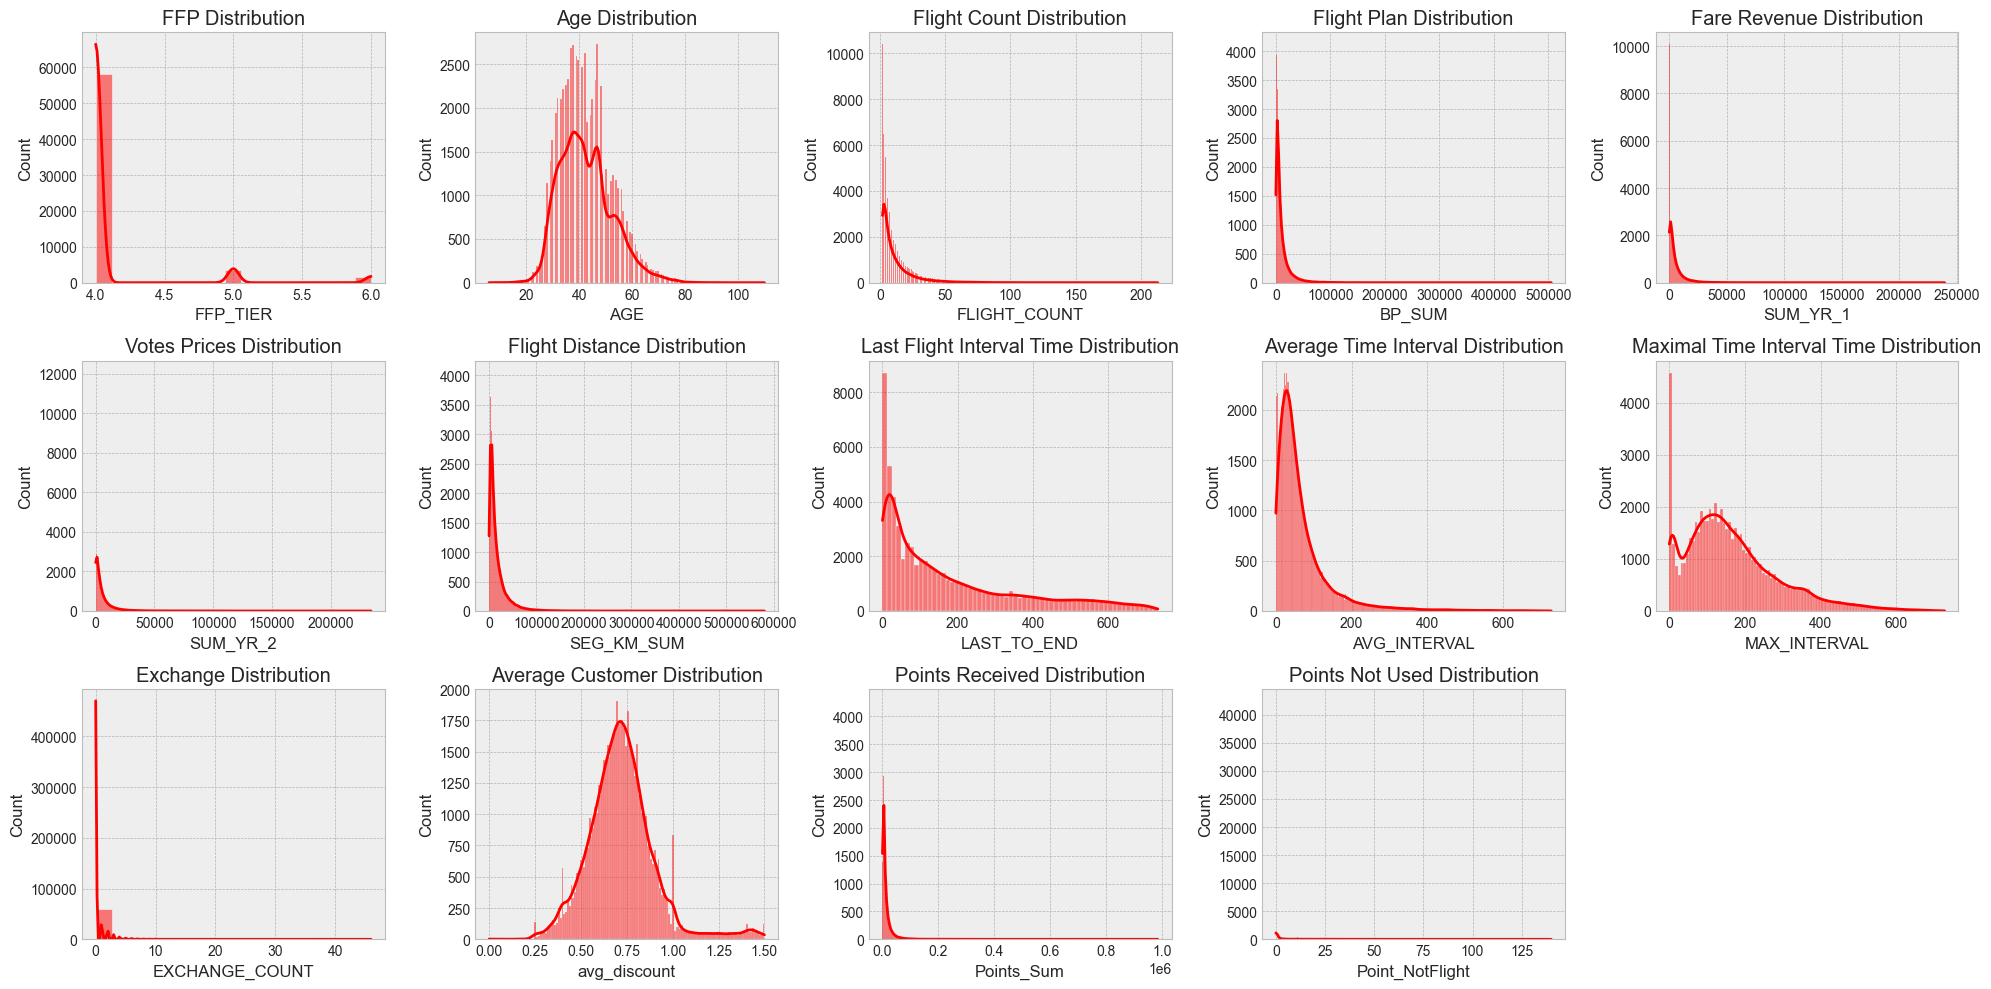

In [220]:
columns = list(df_num)

titles = ['FFP Distribution', 'Age Distribution', 'Flight Count Distribution', 'Flight Plan Distribution', 
          'Fare Revenue Distribution', 'Votes Prices Distribution', 'Flight Distance Distribution', 
          'Last Flight Interval Time Distribution', 'Average Time Interval Distribution', 
          'Maximal Time Interval Time Distribution', 'Exchange Distribution', 
          'Average Customer Distribution', 'Points Received Distribution', 
          'Points Not Used Distribution']

f, ax = plt.subplots(3, 5, figsize=(20, 10))
ax = ax.flatten()

for i, (column, title) in enumerate(zip(columns, titles)):
    sns.histplot(df[column], ax=ax[i], kde=True, color='red')
    ax[i].set_title(title)

for j in range(len(columns), len(ax)):
    f.delaxes(ax[j])

plt.tight_layout()
plt.show()

* `FFP_TIER` is actually categorical data since it has discrete values (4,5,6).
* `Points_Sum` has many unique values, there is no need to remove outliers from them.
* `EXCHANGE_COUNT` and `Point_NotFlight` based on observation above (conditional), there is no need to remove outliers.
* Most of the features are positively skewed and have some extreme features.

#### **Categorical Data**

Categorical Data we'll be focusing on are `WORK_CITY`, `WORK_PROVINCE`, `WORK_COUNTRY`

In [221]:
WORK_CITY = df['WORK_CITY'].value_counts().reset_index()
WORK_CITY.columns = ['WORK_CITY', 'COUNT']
WORK_CITY['PERCENTAGE'] = round((WORK_CITY['COUNT'] / WORK_CITY['COUNT'].sum()) * 100 , 2)
WORK_CITY = WORK_CITY[0:10]
WORK_CITY

,WORK_CITY,COUNT,PERCENTAGE
0,guangzhou,9386,15.46
1,beijing,7845,12.92
2,shanghai,5001,8.24
3,shenzhen,3605,5.94
4,dalian,1979,3.26
5,shenyang,1626,2.68
6,changchun,1528,2.52
7,wulumuqi,1471,2.42
8,wuhan,1156,1.90
9,haerbin,945,1.56


In [222]:
WORK_PROVINCE = df['WORK_PROVINCE'].value_counts().reset_index()
WORK_PROVINCE.columns = ['WORK_PROVINCE', 'COUNT']
WORK_PROVINCE['PERCENTAGE'] = round((WORK_PROVINCE['COUNT'] / WORK_PROVINCE['COUNT'].sum()) * 100 , 2)
WORK_PROVINCE = WORK_PROVINCE[0:10]
WORK_PROVINCE

,WORK_PROVINCE,COUNT,PERCENTAGE
0,guangdong,17509,29.31
1,beijing,8014,13.41
2,shanghai,4998,8.37
3,liaoning,4182,7.00
4,xinjiang,2512,4.20
5,jilin,1823,3.05
6,heilongjiang,1429,2.39
7,hubei,1377,2.30
8,henan,1187,1.99
9,jiangsu,1113,1.86


In [223]:
WORK_COUNTRY = df['WORK_COUNTRY'].value_counts().reset_index()
WORK_COUNTRY.columns = ['WORK_COUNTRY', 'COUNT']
WORK_COUNTRY['PERCENTAGE'] = round((WORK_COUNTRY['COUNT'] / WORK_COUNTRY['COUNT'].sum()) * 100 , 2)
WORK_COUNTRY = WORK_COUNTRY[0:10]
WORK_COUNTRY

,WORK_COUNTRY,COUNT,PERCENTAGE
0,CN,57748,91.72
1,HK,991,1.57
2,JP,875,1.39
3,KR,790,1.25
4,US,575,0.91
5,TW,281,0.45
6,SG,281,0.45
7,AU,271,0.43
8,MY,161,0.26
9,PH,137,0.22


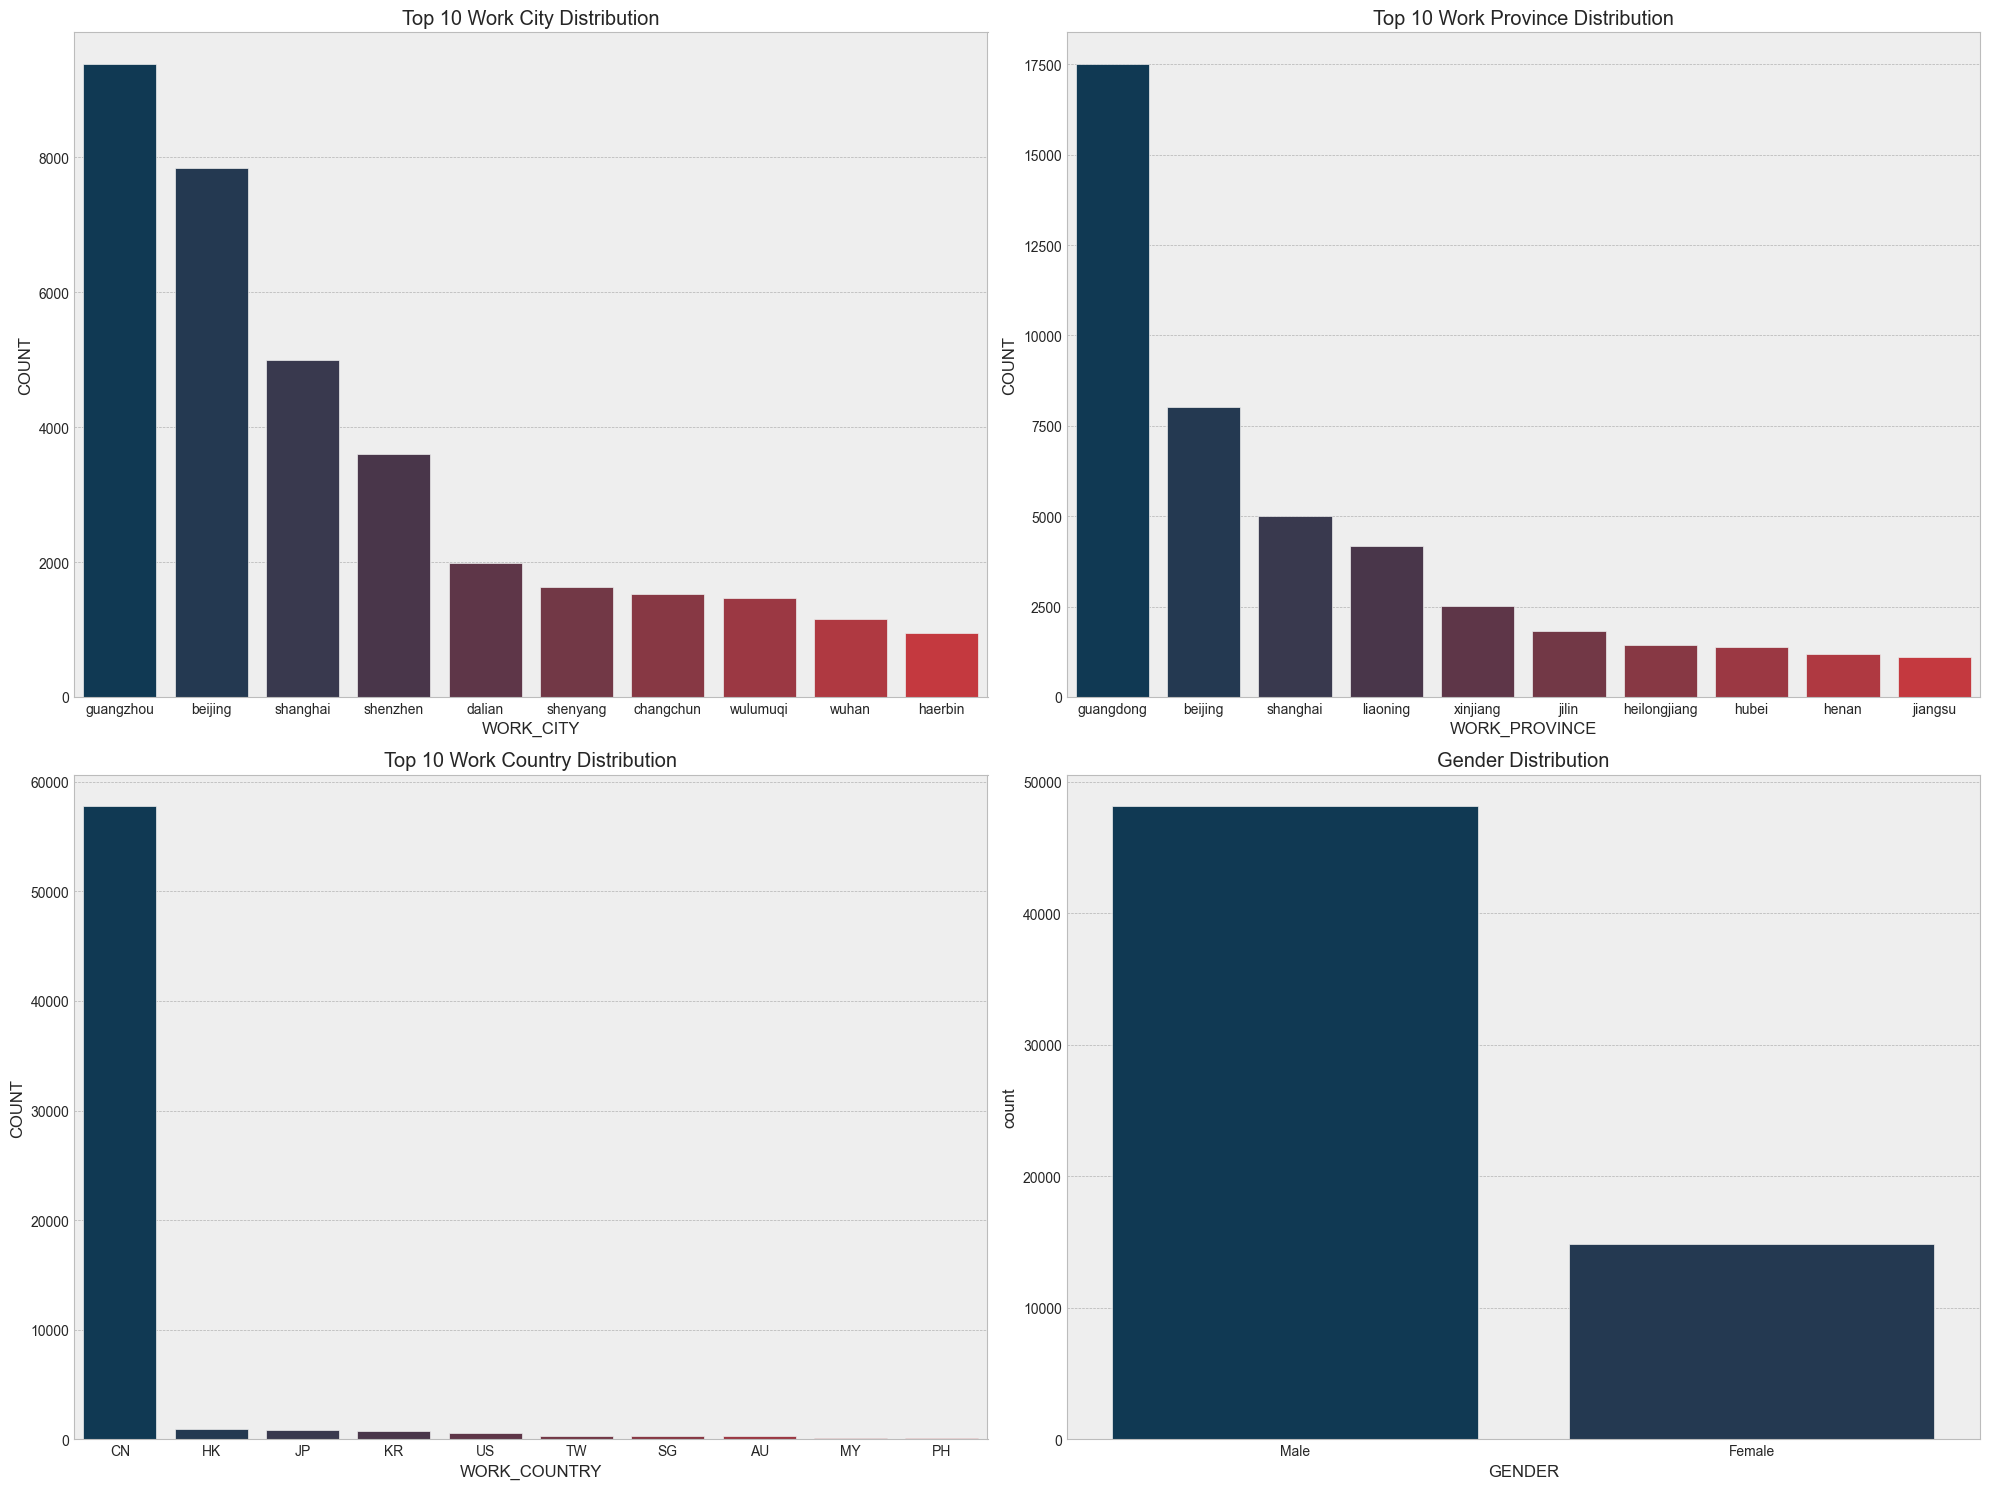

In [224]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

plt_1 = sns.barplot(x='WORK_CITY', y='COUNT', data=WORK_CITY, ax=ax[0,0], palette=colors)
ax[0,0].set_title('Top 10 Work City Distribution')

plt_2 = sns.barplot(x='WORK_PROVINCE', y='COUNT', data=WORK_PROVINCE, ax=ax[0,1], palette=colors)
ax[0,1].set_title('Top 10 Work Province Distribution')

plt_3 = sns.barplot(x='WORK_COUNTRY', y='COUNT', data=WORK_COUNTRY, ax=ax[1,0], palette=colors)
ax[1,0].set_title('Top 10 Work Country Distribution')

plt_4 = sns.countplot(x='GENDER', data=df_non_num, ax=ax[1,1], palette=colors)
ax[1,1].set_title('Gender Distribution')

plt.tight_layout()

Over 90% of the data works in China. Considering on a cultural perspective, they usually have relatively same spending habbits. So we might ignore them in the feature selection process / model construction.

### **Bivariate & Multivariate Analysis**

#### **Correlation Matrix**

<Axes: >

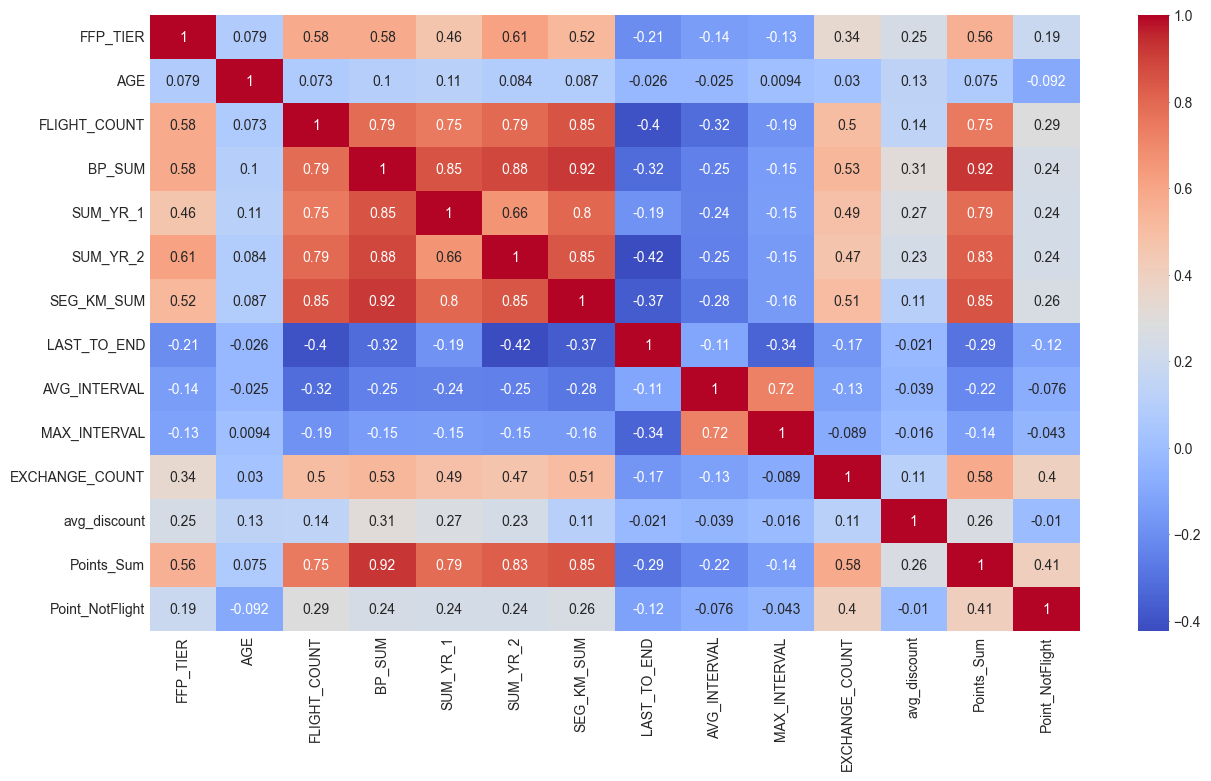

In [225]:
corr = df_num.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

* `SEG_KM_SUM`, `FLIGHT_COUNT`, `BP_SUM`, `SUM_YR_1`, and `SUM_YR_2` are correlated to each other.
* `Points_Sum` are correlated with `FLIGHT_COUNT`, `SUM_YR_2`, and `SEG_KM_SUM`.

## **Data Preperation (For Clustering)**

In [226]:
dff = df.copy()

### **Missing Value & Duplication Handling**

In [227]:
data_info(dff)

Rows,Columns (62988, 22)
Duplicated Values 1
=====


,missingValue,percentMissing,DataType,Unique
WORK_PROVINCE,3248,5.156538,object,1165
WORK_CITY,2269,3.602273,object,3234
SUM_YR_1,551,0.874770,float64,15828
AGE,420,0.666794,float64,84
SUM_YR_2,138,0.219089,float64,16767
WORK_COUNTRY,26,0.041278,object,118
GENDER,3,0.004763,object,2
LAST_FLIGHT_DATE,0,0.000000,object,731
Points_Sum,0,0.000000,int64,25062
avg_discount,0,0.000000,float64,54179


In [228]:
missingVals = dff.isnull().sum().reset_index()
missingVals.columns = ['FEATURE', 'MISSING_VALUE']
missingVals['PERCENTAGE'] = round((missingVals['MISSING_VALUE'] / len(dff) * 100), 2)
missingVals = missingVals.sort_values('PERCENTAGE', ascending=False).reset_index(drop=True)
missingVals = missingVals[missingVals['PERCENTAGE'] > 0]
missingVals

,FEATURE,MISSING_VALUE,PERCENTAGE
0,WORK_PROVINCE,3248,5.16
1,WORK_CITY,2269,3.60
2,SUM_YR_1,551,0.87
3,AGE,420,0.67
4,SUM_YR_2,138,0.22
5,WORK_COUNTRY,26,0.04


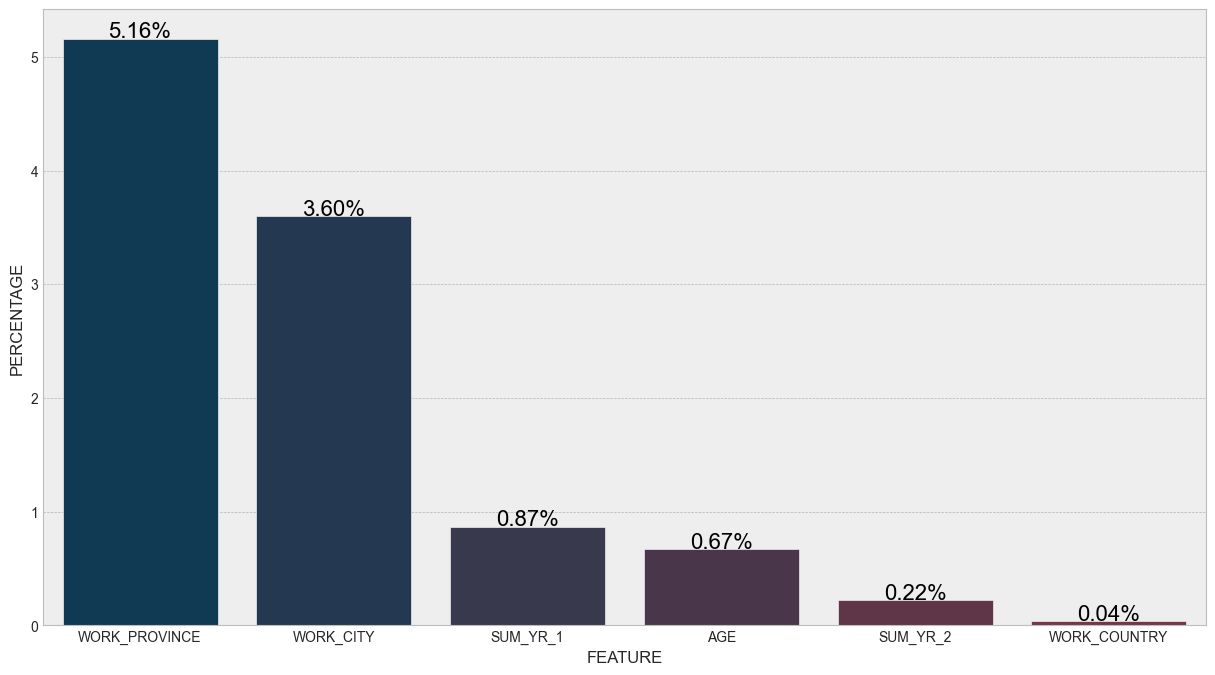

In [229]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='FEATURE', y='PERCENTAGE', data=missingVals, palette=colors)

for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=16, color='black', xytext=(0, 5),
                    textcoords='offset points')

**Distribution of Missing Value**
* WORK_PROVINCE
> 3248 missing values (5.16%)

* WORK_CITY
> 2269 missing values (3.60%)

* SUM_YR_1
> 551 missing values (0.87%)

* AGE
> 420 missing values (0.67%)

* SUM_YR_2
> 138 missing values (0.22%)

* WORK_COUNTRY
> 26 missing values (0.04%)


Since all missing values are under 10%, it is optimal if we remove rows of missing data.

In [230]:
dff = dff.dropna()

In [231]:
dff.isnull().values.any()

False

There is also 1 duplicate, we remove it since it doesn't affect our data highly.

In [232]:
dff.drop_duplicates(inplace = True)

In [233]:
data_info(dff)

Rows,Columns (58254, 22)
Duplicated Values 0
=====


,missingValue,percentMissing,DataType,Unique
FFP_DATE,0,0.0,object,3062
FIRST_FLIGHT_DATE,0,0.0,object,3399
Points_Sum,0,0.0,int64,24321
avg_discount,0,0.0,float64,50667
EXCHANGE_COUNT,0,0.0,int64,27
MAX_INTERVAL,0,0.0,int64,706
AVG_INTERVAL,0,0.0,float64,10538
LAST_TO_END,0,0.0,int64,731
LAST_FLIGHT_DATE,0,0.0,object,731
SEG_KM_SUM,0,0.0,int64,28124


### **Feature Selection**

RFM analysis is one of the most widely used, user-friendly, and efficient segmentation techniques that allows marketers to examine consumer behavior. When segmenting customers in aviation data, based on this [paper](https://www.researchgate.net/publication/343777831_Analysis_Method_for_Customer_Value_of_Aviation_Big_Data_Based_on_LRFMC_Model), they recommend using the LRFMC model, which includes an extra Length and Cost Coefficient parameter. That's why we use LRFMC model in this clustering analysis.

**Length**: `LOAD_TIME` - `FPP_DATE`
* the number of days from the passenger's first day of registration to the time of observation. A higher number indicates a longer membership period.

**Recency**: `LAST_TO_END`
* the time interval between a passenger's most recent consumption and the observation window. The lower the number, the more recent the flight.

**Frequency**: `FLIGHT_COUNT`
* the frequency of the passenger's consumption over a predetermined duration. Greater numbers indicate more frequent flights.

**Monetary**: `SEG_KM_SUM`
* the mean expenditure over a given time frame. A higher number indicates that they made larger purchases.

**Discount (C)**: `avg_discount`
* the typical space-discount percentage for travelers within a specific time frame A higher figure indicates greater usage of discounts.

#### **Feature Engineering**

In [234]:
dff['FFP_DATE']= pd.to_datetime(dff['FFP_DATE'])
dff['LOAD_TIME']= pd.to_datetime(dff['LOAD_TIME'])

In [235]:
data = dff[['LOAD_TIME', 'FFP_DATE', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
data.head()

,LOAD_TIME,FFP_DATE,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,avg_discount
0,2014-03-31,2006-11-02,1,210,580717,0.961639
2,2014-03-31,2007-02-01,11,135,283712,1.254676
3,2014-03-31,2008-08-22,97,23,281336,1.090870
4,2014-03-31,2009-04-10,5,152,309928,0.970658
5,2014-03-31,2008-02-10,79,92,294585,0.967692


In [236]:
data.duplicated().sum()

81

In [237]:
data = data.drop_duplicates()

In [238]:
data['L'] = data['LOAD_TIME'] - data['FFP_DATE']
data['L'] = (data['L'].astype(str).str.split().str[0]).astype(int)

In [239]:
data = data[['L', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]
data.columns = ['L','R','F','M','C']
data.head()

,L,R,F,M,C
0,2706,1,210,580717,0.961639
2,2615,11,135,283712,1.254676
3,2047,97,23,281336,1.090870
4,1816,5,152,309928,0.970658
5,2241,79,92,294585,0.967692


### **Outlier Handling**

===== L =====
 outlier lower limit : -1428.0 
 outlier upper limit : 4308.0
Number of outliers: 0 (0.0%)

===== R =====
 outlier lower limit : -315.5 
 outlier upper limit : 600.5
Number of outliers: 2090 (3.59%)

===== F =====
 outlier lower limit : -15.0 
 outlier upper limit : 33.0
Number of outliers: 4120 (7.08%)

===== M =====
 outlier lower limit : -20103.0 
 outlier upper limit : 46617.0
Number of outliers: 4413 (7.59%)

===== C =====
 outlier lower limit : 0.31854885149999984 
 outlier upper limit : 1.1020308155000003
Number of outliers: 2360 (4.06%)



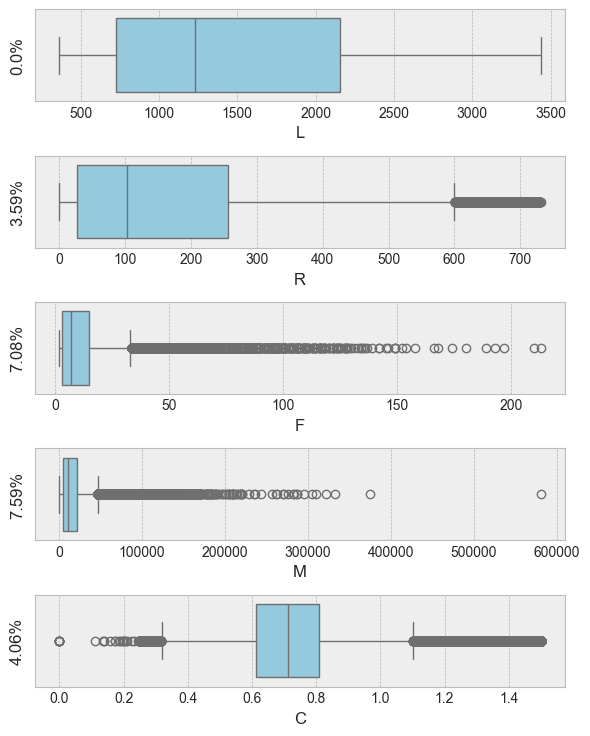

In [240]:
plt.figure(figsize=(6,10))
features = ['L', 'R', 'F', 'M', 'C']
for i in range(0, len(features)):
    plt.subplot(7, 1, i+1)
    sns.boxplot(x=data[features[i]], color='skyblue')
    plt.ylabel(f'{outlier(data, features[i])}%')
    plt.tight_layout()

In [241]:
data.shape

(58173, 5)

`L`, `R`, `F`, and `M` are positively skewd, and `C` looks fairly normal on a skew level. Here we may need to handle outliers for specifically `F` and `M` since it is on an extreme level of positive skew.

In [242]:
feat = 'M'
q1 = data[feat].quantile(0.25)
q3 = data[feat].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

data_no_ol = data[((data[feat] >= lower) & (data[feat] <= upper))]

In [243]:
data_no_ol.shape

(53760, 5)

In [244]:
feat = 'F'
q1 = data_no_ol[feat].quantile(0.25)
q3 = data_no_ol[feat].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

data_no_ol = data_no_ol[((data_no_ol[feat] >= lower) & (data_no_ol[feat] <= upper))]

In [245]:
data_no_ol.shape

(51682, 5)

In [246]:
feat = 'C'
q1 = data_no_ol[feat].quantile(0.25)
q3 = data_no_ol[feat].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

data_no_ol = data_no_ol[((data_no_ol[feat] >= lower) & (data_no_ol[feat] <= upper))]

In [247]:
data_no_ol.shape

(49911, 5)

===== L =====
 outlier lower limit : -1374.5 
 outlier upper limit : 4157.5
Number of outliers: 0 (0.0%)

===== R =====
 outlier lower limit : -330.0 
 outlier upper limit : 654.0
Number of outliers: 1014 (2.03%)

===== F =====
 outlier lower limit : -10.5 
 outlier upper limit : 25.5
Number of outliers: 947 (1.9%)

===== M =====
 outlier lower limit : -13518.5 
 outlier upper limit : 34573.5
Number of outliers: 1714 (3.43%)

===== C =====
 outlier lower limit : 0.3036133334999999 
 outlier upper limit : 1.0939777775000001
Number of outliers: 148 (0.3%)



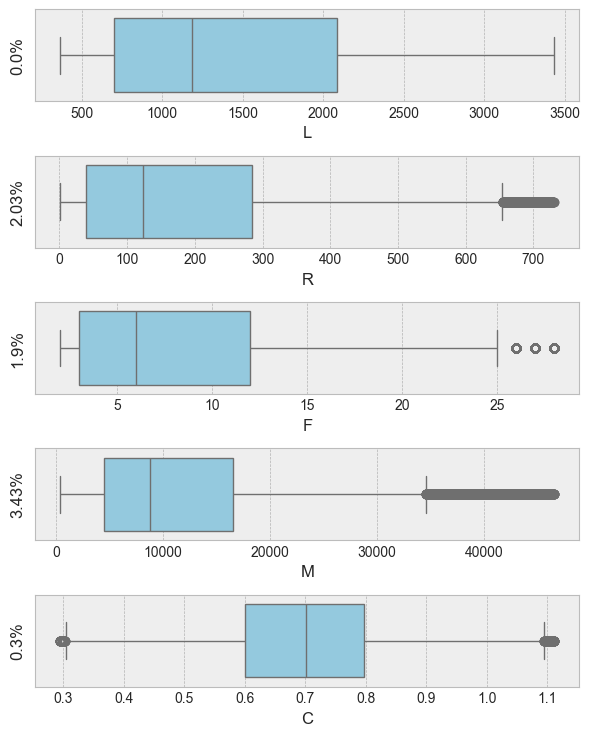

In [248]:
plt.figure(figsize=(6,10))
features = ['L', 'R', 'F', 'M', 'C']
for i in range(0, len(features)):
    plt.subplot(7, 1, i+1)
    sns.boxplot(x=data_no_ol[features[i]], color='skyblue')
    plt.ylabel(f'{outlier(data_no_ol, features[i])}%')
    plt.tight_layout()

### **Feature Transformation**

In [249]:
data_no_ol['L'] = np.log1p(data_no_ol['L'])
data_no_ol['R'] = np.log1p(data_no_ol['R'])
data_no_ol['F'] = np.log1p(data_no_ol['F'])
data_no_ol['M'] = np.log1p(data_no_ol['M'])
data_no_ol['C'] = np.log1p(data_no_ol['C'])

===== L =====
 outlier lower limit : 4.918203113276588 
 outlier upper limit : 9.276349176631259
Number of outliers: 0 (0.0%)

===== R =====
 outlier lower limit : 0.7382109190550623 
 outlier upper limit : 8.606660345878726
Number of outliers: 527 (1.06%)

===== F =====
 outlier lower limit : -0.38168813339257857 
 outlier upper limit : 4.332931851974006
Number of outliers: 0 (0.0%)

===== M =====
 outlier lower limit : 6.468702886269987 
 outlier upper limit : 11.6604374179623
Number of outliers: 19 (0.04%)

===== C =====
 outlier lower limit : 0.2953378276892319 
 outlier upper limit : 0.761113298506575
Number of outliers: 407 (0.82%)



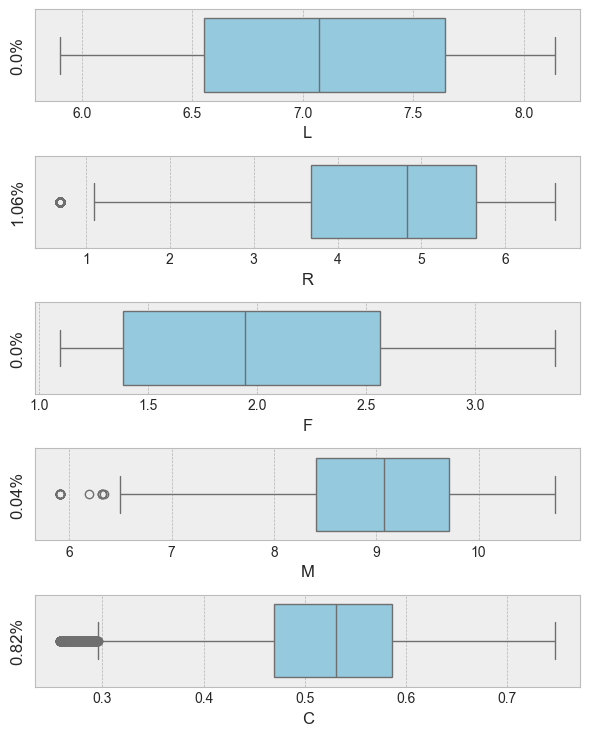

In [250]:
plt.figure(figsize=(6,10))
features = ['L', 'R', 'F', 'M', 'C']
for i in range(0, len(features)):
    plt.subplot(7, 1, i+1)
    sns.boxplot(x=data_no_ol[features[i]], color='skyblue')
    plt.ylabel(f'{outlier(data_no_ol, features[i])}%')
    plt.tight_layout()

### **Data Scalling / Standardization**

In [251]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data_no_ol.astype(float))

In [252]:
data_std = pd.DataFrame(data=data_std, columns=data.columns)
data_std.head()

,L,R,F,M,C
0,1.175862,-1.272931,2.065328,1.985479,2.447163
1,0.592429,-1.590830,0.964487,1.959035,2.518066
2,0.988004,0.084006,0.296590,1.971484,2.141721
3,1.109674,1.098046,-0.083309,1.967779,2.013518
4,1.418706,-2.166615,1.840969,1.882038,2.383667


## **Modelling**

### **Elbow Plot (Finding optimal K)**

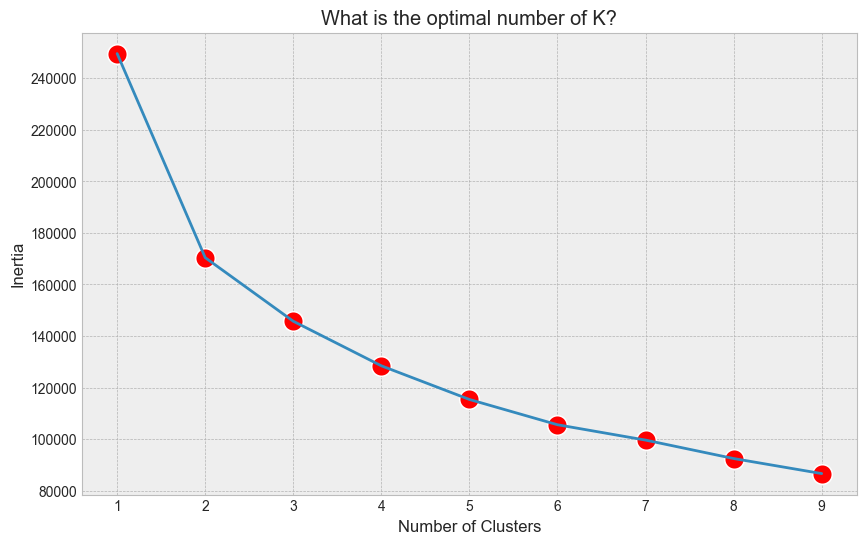

In [253]:
inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_std)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 10), y=inertia, linewidth = 2)
sns.scatterplot(x=range(1, 10), y=inertia, s=200, color='red')
plt.xticks(range(1, 10))
plt.title('What is the optimal number of K?')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


From the elbow plot above, there is a possibility that the optimum number of clusters is 5. Due to the fact afteer 5, the drop off inertia tends to flat out insisting too much clustering may occur.

### **5 Clusters**

In [254]:
data_5c = data_std.copy()
kmeans_5 = KMeans(n_clusters=5, random_state=0)
kmeans_5.fit(data_5c)

KMeans(n_clusters=5, random_state=0)

In [255]:
data_5c['CLUSTER'] = kmeans_5.labels_
data_5c.head()

,L,R,F,M,C,CLUSTER
0,1.175862,-1.272931,2.065328,1.985479,2.447163,3
1,0.592429,-1.590830,0.964487,1.959035,2.518066,3
2,0.988004,0.084006,0.296590,1.971484,2.141721,3
3,1.109674,1.098046,-0.083309,1.967779,2.013518,0
4,1.418706,-2.166615,1.840969,1.882038,2.383667,3


In [256]:
radar_plot_5 = data_5c.groupby('CLUSTER').agg('median').reset_index()
radar_plot_5

,CLUSTER,L,R,F,M,C
0,0,0.997639,0.373374,-0.316331,-0.107322,0.172574
1,1,-0.564680,0.892957,-0.929252,-1.072461,0.780366
2,2,-0.890985,-0.160370,0.599934,0.582197,0.086673
3,3,0.824656,-0.882907,1.257982,1.107570,0.104992
4,4,-0.446640,0.651215,-0.929252,-0.723635,-1.319915


### **Visualize**

<Axes: xlabel='PC1', ylabel='PC2'>

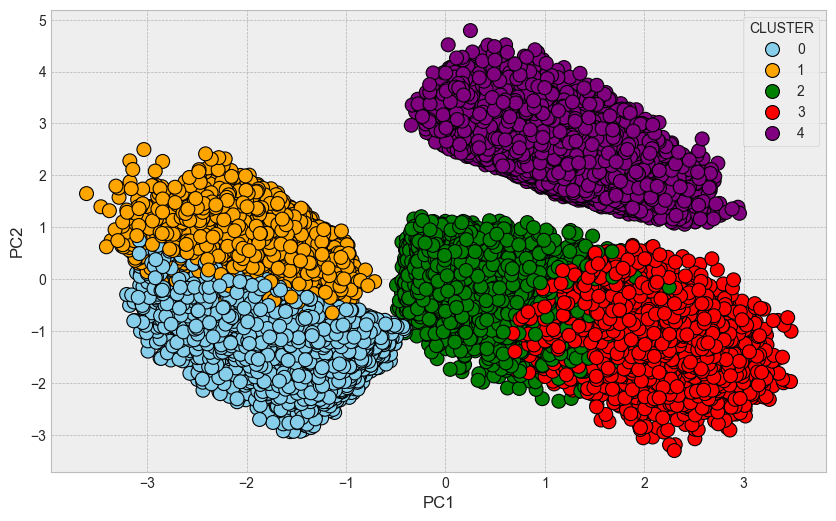

In [293]:
pca = PCA(n_components=2)

pca.fit(data_5c)
pcs = pca.transform(data_5c)

data_pca = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])
data_pca['CLUSTER'] = data_5c['CLUSTER']

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(x = 'PC1', y = 'PC2', hue='CLUSTER', data = data_pca, palette=['skyblue', 'orange', 'green', 'red', 'purple'], edgecolor='black', s=100, ax=ax)


## **Analytical Insights**

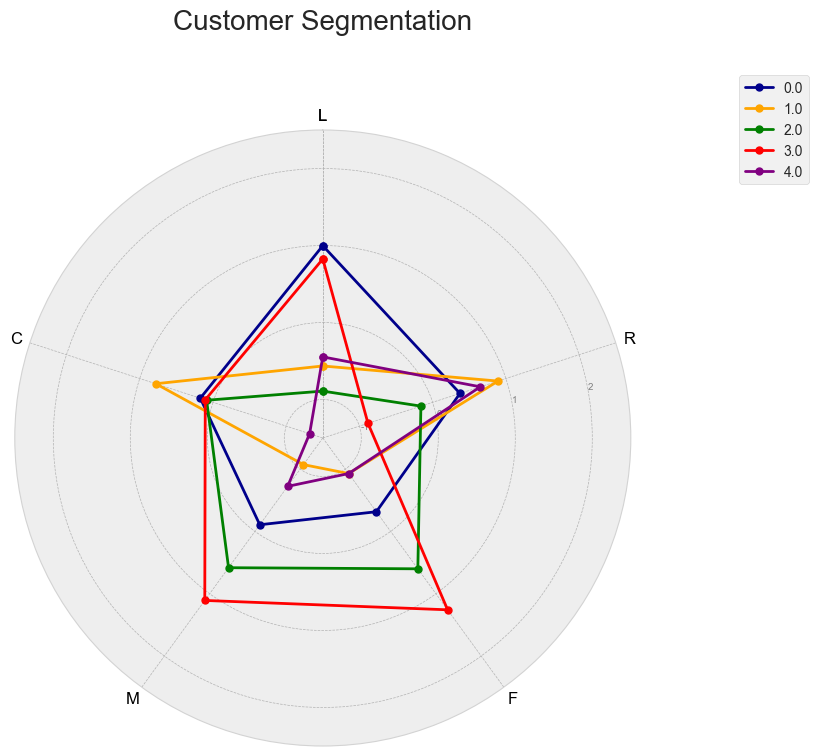

In [292]:
features = ['L', 'R', 'F', 'M', 'C']

N = len(features)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
theta = np.concatenate([theta, [theta[0]]])

features_for_radar = np.concatenate([features, [features[0]]])
clusters = []

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

ax.set_title('Customer Segmentation', y=1.15, fontsize=20)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(80)
ax.spines['polar'].set_zorder(1)
ax.spines['polar'].set_color('lightgrey')

color_palette = ['darkblue', 'orange', 'green', 'red', 'purple', 'black']
    
for idx, (i, row) in enumerate(radar_plot_5.iterrows()):
    num = []
    for feat in features:
        num.append(radar_plot_5[feat][i])
    num.append(radar_plot_5['L'][i])
    clusters.append(num)

    values = row[features].values.flatten().tolist()
    values = values + [values[0]]
    ax.plot(theta, values, linewidth=2, label=row['CLUSTER'], marker='o', markersize=5, color=color_palette[idx % len(color_palette)])
    
plt.xticks(theta, features + [features[0]], color='black', size=12)
plt.yticks([-1,0,1,2], ["-1","0","1","2"], color="grey", size=7)
plt.ylim(-1.5,2.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1)) 
plt.show()

In [299]:
def individual_radars(cluster_n, title):
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})

    ax.set_title('Customer Segmentation', y=1.15, fontsize=20)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(70)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')

    lines, labels = plt.thetagrids(np.degrees(theta), labels=features_for_radar)
    plt.yticks([-1,0,1,2], ["-1","0","1","2"], color="grey", size=7)
    plt.ylim(-1.5,2.5)
    plt.plot(theta, clusters[cluster_n], color=color_palette[cluster_n], label = title, marker='o', markersize=5)
    ax.fill(theta, clusters[cluster_n], alpha=0.25, color=color_palette[cluster_n])
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1)) 
    plt.show()

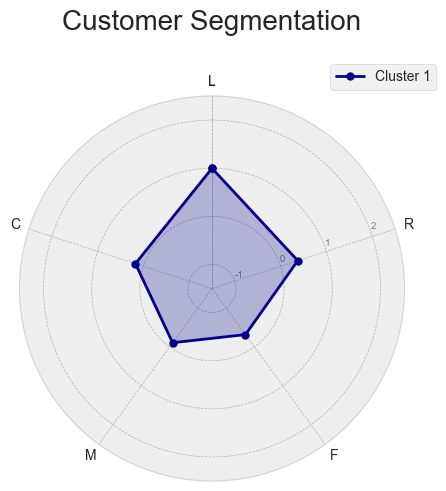

In [300]:
individual_radars(0, 'Cluster 1')

* Cluster 1 (Promising)
> Has average L, R, and C values, and not so fairly low F and M values. These customers are relatively new but show potential for becoming loyal. They have recently started engaging with the airline but have not yet reached the highest level of activity or spending.

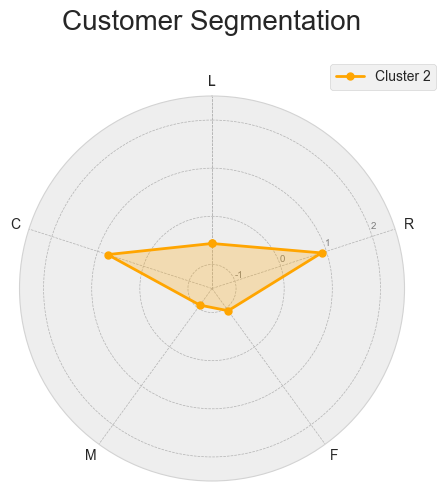

In [301]:
individual_radars(1, 'Cluster 2')

* Cluster 2 (Price Sensitive)
> Has high R, and C values while low on every other aspect. These customers are highly motivated by price and may switch airlines for better deals. They are likely to book flights based on cost rather than loyalty.

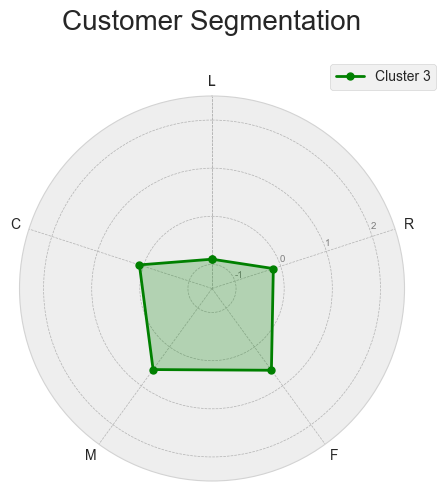

In [302]:
individual_radars(2, 'Cluster 3')

* Cluster 3 (Need Attention)
> Has fairly average F & M values, average C & R values, and low L value. These customers may have previously been active but have reduced their engagement. They might be dissatisfied or have found alternatives.

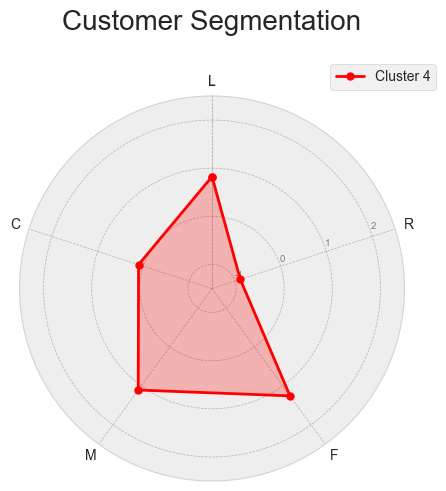

In [303]:
individual_radars(3, 'Cluster 4')

* Cluster 4 (Champions)
> Extremely high L, F & M value, average C value, and low R value. These are the airline’s most loyal and valuable customers. They frequently book flights and contribute significantly to revenue.

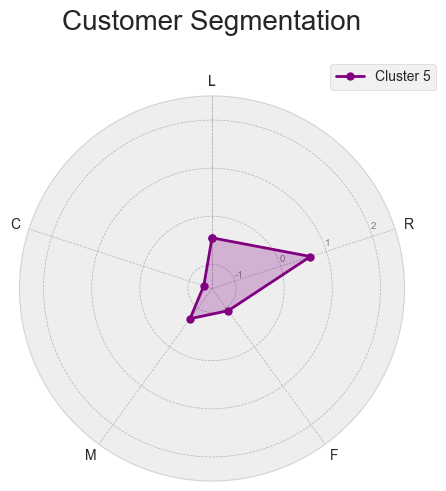

In [304]:
individual_radars(4, 'Cluster 5')

* Cluster 5 (Hibernating)
> Has average L, R & M values, with low F and C values. These customers have not engaged with the airline for a long time. They are inactive but have the potential to return.

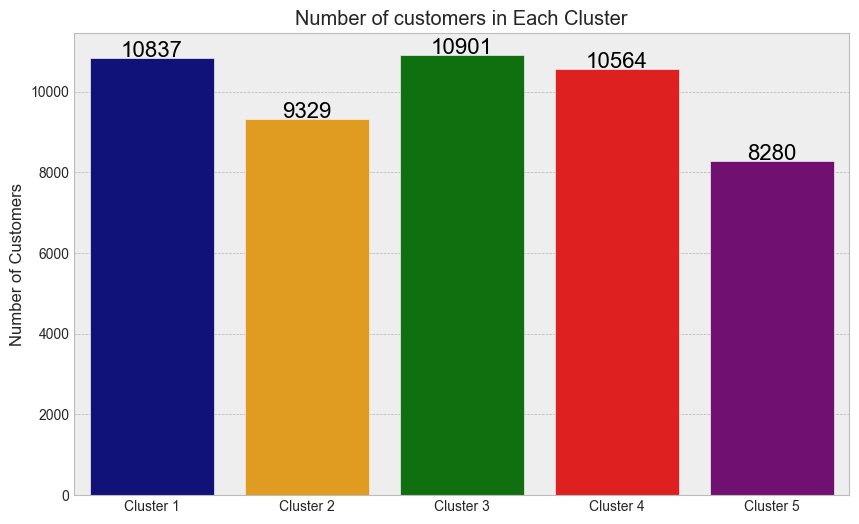

In [269]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data_5c['CLUSTER'], palette=color_palette)
for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=16, color='black', xytext=(0, 5),
                    textcoords='offset points')
plt.xticks([0,1,2,3,4], ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"])
plt.title("Number of customers in Each Cluster")
plt.xlabel("")
plt.ylabel("Number of Customers")
plt.show()

Based on LRMFC Model, we get 5 clusters from our customers, which are as follows:
1. Cluster 1 - **Promising Customers** (10837 customers)
2. Cluster 2 - **Price Sensitive Customers** (9329 customers)
3. Cluster 3 - **Customers that Need Attention** (10901 customers)
4. Cluster 4 - **Champion Customers** (10564 customers)
5. Cluster 5 - **Hibernating Customers** (8280 customers)

## **Business Recommendations**

**1. Welcome Offers, Discounts, and Promotions**<br>
Engage new and price-sensitive customers with attractive deals.

**2. Loyalty and Recognition Programs**<br>
Build long-term relationships with promising and champion customers through loyalty programs and exclusive benefits.

**3. Personalized Communication and Services**<br>
Tailor messages and services to meet the specific needs of each customer cluster.

**4. Re-engagement and Win-back Campaigns**<br>
Focus on reactivating customers who need attention or have become inactive.

**5. Feedback and Customer Support**<br>
Continuously gather feedback and provide exceptional support to address customer needs and improve satisfaction.


## **Business Recommendations For Each Cluster**

**1. Promising Customers**
- Provide special welcome discounts or miles to encourage repeat purchases.
- Introduce them to the benefits of the airline's loyalty program.
- Send personalized messages highlighting the benefits and services of the airline.

**2. Price Sensitive Customers**
- Regularly offer discounts, deals, and special promotions to keep them engaged.
- Provide options like fare classes that allow for cost-saving.
- Highlight cost-saving benefits like free baggage, meals, or flexible change policies.
- Create loyalty program tiers that cater to budget-conscious travelers.

**3. Customers that Need Attention**
- Send targeted campaigns to re-engage them, such as special offers or reminders of upcoming trips.
-  Offer incentives to try new or improved services.

**4. Champion Customers**
- Offer exclusive perks such as priority boarding, lounge access, and upgrades.
- Provide personalized travel experiences and dedicated account managers.
- Recognize their loyalty through special events, gifts, or acknowledgment in communication.
- Encourage them to refer others by offering referral bonuses.

**5. Hibernating Customers**
- Launch win-back campaigns with strong incentives to reactivate their engagement.
- Send periodic check-ins or updates about new routes, services, or offers.
- Send targeted seasonal offers that align with common travel times or holidays.